In [ ]:
# Install libraries
!pip uninstall torch torchvision torchaudio -y

!pip install --upgrade pip

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install opencv-python-headless
!pip install Pillow
!pip install scikit-image
!pip install imageio

!pip install numpy pandas matplotlib seaborn
!pip install scikit-learn
!pip install tqdm

!pip install albumentations
!pip install segmentation-models-pytorch

!pip install wandb

print("Library installation complete!")

In [ ]:
# Import Libraries

import sys
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import cv2
from PIL import Image
import skimage
from skimage import io, transform, filters
import imageio

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

print("All libraries imported successfully")

In [ ]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/MyDrive'
PROJECT_PATH = f'{DRIVE_PATH}/9517'
DATA_PATH = f'{PROJECT_PATH}/USA_segmentation'

os.makedirs(PROJECT_PATH, exist_ok=True)
os.makedirs(f'{PROJECT_PATH}/models', exist_ok=True)
os.makedirs(f'{PROJECT_PATH}/results', exist_ok=True)
os.makedirs(f'{PROJECT_PATH}/logs', exist_ok=True)
os.makedirs(f'{PROJECT_PATH}/visualizations', exist_ok=True)

print(f"Project Path: {PROJECT_PATH}")
print(f"Dataset Path: {DATA_PATH}")
print("Drive connected successfully!")

Mounted at /content/gdrive
Project Path: /content/gdrive/MyDrive/9517
Dataset Path: /content/gdrive/MyDrive/9517/USA_segmentation
Drive connected successfully!


In [ ]:
# Verification of environment settings
def print_system_info():
    """Print detailed system information"""
    print("=== Detailed System Information ===")
    print(f"Operating System: {os.name}")
    print(f"Python Version: {sys.version}")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"Torchvision Version: {torchvision.__version__}")
    print(f"NumPy Version: {np.__version__}")
    print(f"OpenCV Version: {cv2.__version__}")

    if torch.cuda.is_available():
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"cuDNN Version: {torch.backends.cudnn.version()}")
        for i in range(torch.cuda.device_count()):
            props = torch.cuda.get_device_properties(i)
            print(f"GPU {i}: {props.name}")
            print(f"  - Memory: {props.total_memory / 1024**3:.1f} GB")
            print(f"  - Compute Capability: {props.major}.{props.minor}")
    else:
        print("CUDA is not available, using CPU")
    print("=" * 30)

def check_directory_structure():
    """Check the project directory structure"""
    print("=== Project Directory Structure ===")
    directories = [
        PROJECT_PATH,
        f'{PROJECT_PATH}/models',
        f'{PROJECT_PATH}/results',
        f'{PROJECT_PATH}/logs',
        f'{PROJECT_PATH}/visualizations',
        DATA_PATH
    ]

    for directory in directories:
        exists = os.path.exists(directory)
        status = "✓" if exists else "✗"
        print(f"{status} {directory}")

        if exists and os.path.isdir(directory):
            files = os.listdir(directory)
            if files:
                print(f"    Contains {len(files)} file(s)/folder(s)")
    print("=" * 25)

print_system_info()
check_directory_structure()
print("\n Environment setup complete!")

In [ ]:
# Dataset exploration, preprocessing, and partitioning
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import random
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# Setting the data path
RGB_PATH = '/content/gdrive/MyDrive/9517/USA_segmentation/RGB_images'
NRG_PATH = '/content/gdrive/MyDrive/9517/USA_segmentation/NRG_images'
MASK_PATH = '/content/gdrive/MyDrive/9517/USA_segmentation/masks'

# ====================================================================
# 1. Exploration of basic information about the dataset
# ====================================================================

def explore_dataset_structure():
    """Explore basic information about the dataset"""
    print("== Exploring the structure of datasets ==")

    paths = {
        'RGB_images': RGB_PATH,
        'NRG_images': NRG_PATH,
        'masks': MASK_PATH
    }

    dataset_info = {}

    for name, path in paths.items():
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.png')]
            dataset_info[name] = {
                'count': len(files),
                'files': files[:5],  # display the first 5 file names
                'path': path
            }
            print(f"✓ {name}: {len(files)} pictures")
        else:
            print(f"✗ {name}: The path does not exist!")
            dataset_info[name] = {'count': 0, 'files': [], 'path': path}

    return dataset_info

def check_file_correspondence():
    """Checking file correspondence"""
    print("\n== Checking file correspondence ==")

    # Get the base name of all filenames
    rgb_files = [f for f in os.listdir(RGB_PATH) if f.endswith('.png')]
    nrg_files = [f for f in os.listdir(NRG_PATH) if f.endswith('.png')]
    mask_files = [f for f in os.listdir(MASK_PATH) if f.endswith('.png')]

    # Extract base name (remove prefix)
    rgb_bases = [f.replace('RGB_', '') for f in rgb_files]
    nrg_bases = [f.replace('NRG_', '') for f in nrg_files]
    mask_bases = [f.replace('mask_', '') for f in mask_files]

    # Check correspondence
    rgb_set = set(rgb_bases)
    nrg_set = set(nrg_bases)
    mask_set = set(mask_bases)

    common_files = rgb_set & nrg_set & mask_set

    print(f"Number of RGB files: {len(rgb_set)}")
    print(f"Number of NRG files: {len(nrg_set)}")
    print(f"Number of Mask files: {len(mask_set)}")
    print(f"Number of files matched: {len(common_files)}")

    if len(common_files) < min(len(rgb_set), len(nrg_set), len(mask_set)):
        print("== Mismatched files! ==")
        missing_in_rgb = (nrg_set | mask_set) - rgb_set
        missing_in_nrg = (rgb_set | mask_set) - nrg_set
        missing_in_mask = (rgb_set | nrg_set) - mask_set

        if missing_in_rgb: print(f"RGB Missing: {list(missing_in_rgb)[:5]}")
        if missing_in_nrg: print(f"NRG Missing: {list(missing_in_nrg)[:5]}")
        if missing_in_mask: print(f"Mask Missing: {list(missing_in_mask)[:5]}")
    else:
        print("✓ All files match!")

    return list(common_files)

# ====================================================================
# 2. Image size and content analysis
# ====================================================================

def analyze_image_properties(file_list=None, sample_size=10):
    """Analyzing image properties"""
    print(f"\n=== The analysis of image properties (Sample size: {sample_size}) ===")

    if file_list is None:
        file_list = check_file_correspondence()

    # Select sample randomly
    sample_files = random.sample(file_list, min(sample_size, len(file_list)))

    rgb_info = []
    nrg_info = []
    mask_info = []

    for base_name in sample_files:
        # RGB image
        rgb_path = os.path.join(RGB_PATH, f'RGB_{base_name}')
        rgb_img = np.array(Image.open(rgb_path))  # load into a Numpy array
        rgb_info.append({
            'file': base_name,
            'shape': rgb_img.shape,
            'dtype': rgb_img.dtype,
            'min': rgb_img.min(),
            'max': rgb_img.max(),
            'mean': rgb_img.mean()
        })

        # NRG image
        nrg_path = os.path.join(NRG_PATH, f'NRG_{base_name}')
        nrg_img = np.array(Image.open(nrg_path))
        nrg_info.append({
            'file': base_name,
            'shape': nrg_img.shape,
            'dtype': nrg_img.dtype,
            'min': nrg_img.min(),
            'max': nrg_img.max(),
            'mean': nrg_img.mean()
        })

        # Mask image
        mask_path = os.path.join(MASK_PATH, f'mask_{base_name}')
        mask_img = np.array(Image.open(mask_path))
        unique_values = np.unique(mask_img) # Each pixel in each mask represents a semantic category, such as background, vegetation
        mask_info.append({
            'file': base_name,
            'shape': mask_img.shape,
            'dtype': mask_img.dtype,
            'unique_values': unique_values,
            'value_counts': [np.sum(mask_img == val) for val in unique_values]
        })


    print("\n== RGB Image Statistics: ==")
    shapes = [info['shape'] for info in rgb_info]
    print(f"   Size: {Counter(shapes).most_common()}")
    print(f"   Data Type: {rgb_info[0]['dtype']}")
    print(f"   Pixel Value Range: {min(info['min'] for info in rgb_info)} - {max(info['max'] for info in rgb_info)}")

    print("\n== NRG Image Statistics ==:")
    shapes = [info['shape'] for info in nrg_info]
    print(f"   Size: {Counter(shapes).most_common()}")
    print(f"   Data Type: {nrg_info[0]['dtype']}")
    print(f"   Pixel Value Range: {min(info['min'] for info in nrg_info)} - {max(info['max'] for info in nrg_info)}")

    print("\n== Mask Image Statistics ==:")
    shapes = [info['shape'] for info in mask_info]
    print(f"   Size: {Counter(shapes).most_common()}")
    print(f"   Data Type: {mask_info[0]['dtype']}")

    # Analyzing the unique value of mask
    all_unique_values = set()
    for info in mask_info:
        all_unique_values.update(info['unique_values'])
    print(f"   All possible pixel values: {sorted(all_unique_values)}") # 输出结果是0和255，因为这是二类分割的标准编码

    return rgb_info, nrg_info, mask_info

# ====================================================================
# 3. Sample Images Visualation
# ====================================================================

def visualize_samples(file_list, n_samples=4):
    """Visualize samples"""
    print(f"\n== Smaple Visualization (display {n_samples} samples) ==")

    # Take 4 samples
    sample_files = random.sample(file_list, min(n_samples, len(file_list)))

    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, base_name in enumerate(sample_files):
        # Load image
        rgb_path = os.path.join(RGB_PATH, f'RGB_{base_name}')
        nrg_path = os.path.join(NRG_PATH, f'NRG_{base_name}')
        mask_path = os.path.join(MASK_PATH, f'mask_{base_name}')

        rgb_img = np.array(Image.open(rgb_path))
        nrg_img = np.array(Image.open(nrg_path))
        mask_img = np.array(Image.open(mask_path))

        # Display image
        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f'RGB - {base_name}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(nrg_img)
        axes[i, 1].set_title(f'NRG - {base_name}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask_img, cmap='gray')
        axes[i, 2].set_title(f'Mask - {base_name}')
        axes[i, 2].axis('off')

        # Overlay RGB and MASK to check the quality of dataset
        overlay = rgb_img.copy()
        if len(mask_img.shape) == 2:
            mask_colored = np.zeros_like(rgb_img)
            mask_colored[:,:,0] = mask_img  # Red represent mask
            overlay = cv2.addWeighted(overlay, 0.7, mask_colored, 0.3, 0)

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f'RGB + Mask Overlay')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_mask_distribution(file_list, sample_size=50):
    """Analyze the distribution of the target area in the mask"""
    print(f"\n== Mask distribution analysis (Samples: {sample_size})")

    # Take 50 pictures
    sample_files = random.sample(file_list, min(sample_size, len(file_list)))

    dead_tree_ratios = []
    unique_values_stats = []

    for base_name in sample_files:
        mask_path = os.path.join(MASK_PATH, f'mask_{base_name}')
        mask_img = np.array(Image.open(mask_path))

        unique_values = np.unique(mask_img)
        unique_values_stats.append(unique_values)

        # Calculate the percentage of target area (Assuming a non-zero value as the target) 255
        total_pixels = mask_img.size
        if len(unique_values) > 1:
            # Assume that the maximum value is the foreground and the minimum value is the background
            foreground_pixels = np.sum(mask_img == unique_values[-1])
            ratio = foreground_pixels / total_pixels
        else:
            ratio = 0
        dead_tree_ratios.append(ratio)

    print(f"   Percentage of average target area: {np.mean(dead_tree_ratios):.3f}")
    print(f"   Range of percentage of target regions: {np.min(dead_tree_ratios):.3f} - {np.max(dead_tree_ratios):.3f}")

    # Count unique values
    all_values = []
    for values in unique_values_stats:
        all_values.extend(values)
    value_counter = Counter(all_values)
    print(f"   Mask pixel satistics: {dict(value_counter)}")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(dead_tree_ratios, bins=20, alpha=0.7)
    plt.xlabel('Percentage of average target area')
    plt.ylabel('Number of samples')
    plt.title('Distribution of the percentage of target regions')

    plt.subplot(1, 2, 2)
    values, counts = zip(*value_counter.most_common())
    plt.bar(range(len(values)), counts)
    plt.xlabel('Pixel')
    plt.ylabel('Frequency')
    plt.title('Distribution of Mask pixel value')
    plt.xticks(range(len(values)), values)

    plt.tight_layout()
    plt.show()

    return dead_tree_ratios, value_counter

# ====================================================================
# 4. Dataset Class Definitions
# ====================================================================

class ForestSegmentationDataset(Dataset):
    """Forest segmentation dataset class"""

    def __init__(self, file_list, rgb_path, nrg_path, mask_path,
                 image_size=256, use_nir=True, transform=None):
        """
        Args:
            file_list: list of file base names
            rgb_path: RGB image path
            nrg_path: NRG image path
            mask_path: mask image path
            image_size: target image size
            use_nir: whether or not to use the NIR channel
            transform: which data augmentation transform to use
        """
        self.file_list = file_list
        self.rgb_path = rgb_path
        self.nrg_path = nrg_path
        self.mask_path = mask_path
        self.image_size = image_size
        self.use_nir = use_nir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        base_name = self.file_list[idx]

        # Load RGB image
        rgb_path = os.path.join(self.rgb_path, f'RGB_{base_name}')
        rgb_img = np.array(Image.open(rgb_path))

        # Load mask image
        mask_path = os.path.join(self.mask_path, f'mask_{base_name}')
        mask_img = np.array(Image.open(mask_path))

        if self.use_nir:
            nrg_path = os.path.join(self.nrg_path, f'NRG_{base_name}')
            nrg_img = np.array(Image.open(nrg_path))
            nir_channel = nrg_img[:, :, 0]  # N channel

            # Merge to 4-channel image (RGB + NIR)
            image = np.dstack([rgb_img, nir_channel])
        else:
            image = rgb_img

        # Make sure mask is binary
        if len(np.unique(mask_img)) > 2:
            # If not, set the maximum value to 1 and the rest to 0
            mask_img = (mask_img == mask_img.max()).astype(np.uint8)
        else:
            # If it's already binary, make sure it's 0 and 1
            mask_img = (mask_img > 0).astype(np.uint8)

        # Apply transform
        if self.transform:
            transformed = self.transform(image=image, mask=mask_img)
            image = transformed['image']
            mask_img = transformed['mask']

        # Ensure that the mask is float32 and increase the channel dimension.
        if isinstance(mask_img, torch.Tensor):
            mask_img = mask_img.float().unsqueeze(0)
        else:
            mask_img = torch.FloatTensor(mask_img).unsqueeze(0)

        return image, mask_img

# ====================================================================
# 5. Dataset Division
# ====================================================================

def split_dataset(file_list, val_size=0.2, random_state=42):
    """Split the dataset into training and validation set"""
    print(f"\n== Dataset segmentation ==")

    train_files, val_files = train_test_split(
        file_list, test_size=val_size, random_state=random_state
    )

    print(f"   Training Set: {len(train_files)} images")
    print(f"   Test Set: {len(val_files)} images")
    print(f"   Total: {len(file_list)} images")

    return train_files, val_files

In [ ]:
# ====================================================================
# Data Preprocessing
# ====================================================================
valid_files = check_file_correspondence()
train_files, val_files = split_dataset(valid_files)

In [ ]:
# ====================================================================
# Complete Model Training Pipeline - Forest Dead Tree Segmentation Project
# Note: This code requires running data preprocessing code first to obtain train_files, test_files and path variables
# ====================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import os
import json
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Ensure GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Device: {device}")

# ====================================================================
# 1. Multi-channel Color Transform Class
# ====================================================================

class MultiChannelColorTransform(A.ImageOnlyTransform):
    """Multi-channel image color transformation (only applies transforms to RGB channels, keeps NIR and other channels unchanged)"""

    def __init__(self, rgb_color_transforms, channel_config, always_apply=False, p=1.0):
        """
        Args:
            rgb_color_transforms: List of Albumentations color transforms
            channel_config: Channel configuration ('rgb', 'nrg', 'rgb_nir', 'rgb_nrg')
        """
        super(MultiChannelColorTransform, self).__init__(always_apply, p)
        self.rgb_color_transforms = rgb_color_transforms
        self.channel_config = channel_config

    def apply(self, image, **params):
        if self.channel_config == 'rgb_nir' and image.shape[2] == 4:
            # 4 channels: RGB + NIR
            rgb_channels = image[:, :, :3]
            nir_channel = image[:, :, 3:4]

            # Apply color transforms to RGB channels
            transformed_rgb = self.rgb_color_transforms(image=rgb_channels)['image']

            # Recombine channels
            transformed_image = np.concatenate([transformed_rgb, nir_channel], axis=2)
            return transformed_image

        elif self.channel_config == 'rgb_nrg' and image.shape[2] == 6:
            # 6 channels: RGB + NRG
            rgb_channels = image[:, :, :3]
            nrg_channels = image[:, :, 3:6]

            # Apply color transforms to RGB channels
            transformed_rgb = self.rgb_color_transforms(image=rgb_channels)['image']

            # Recombine channels
            transformed_image = np.concatenate([transformed_rgb, nrg_channels], axis=2)
            return transformed_image

        else:
            # RGB or NRG used separately, apply transforms directly
            return self.rgb_color_transforms(image=image)['image']

    @property
    def targets_as_params(self):
        return []

# ====================================================================
# 2. Multi-channel Dataset Class (Extended version supporting different channel configurations)
# ====================================================================

class MultiChannelForestDataset(Dataset):
    """Forest segmentation dataset supporting multiple channel configurations and data augmentation"""

    def __init__(self, file_list, rgb_path, nrg_path, mask_path,
                 channel_config='rgb_nir', augmentation_strategy='light',
                 image_size=256, is_training=True):
        """
        Args:
            channel_config: 'rgb', 'nrg', 'rgb_nir', 'rgb_nrg'
            augmentation_strategy: 'none', 'light', 'medium', 'strong'
        """
        self.file_list = file_list
        self.rgb_path = rgb_path
        self.nrg_path = nrg_path
        self.mask_path = mask_path
        self.channel_config = channel_config
        self.image_size = image_size
        self.is_training = is_training

        # Channel configuration
        self.channel_info = {
            'rgb': 3,
            'nrg': 3,
            'rgb_nir': 4,
            'rgb_nrg': 6  # RGB + NRG channels
        }

        self.num_channels = self.channel_info[channel_config]

        # Data augmentation
        self.transform = self._get_transforms(augmentation_strategy, is_training)

    def _get_transforms(self, strategy, is_training):
        """Get data transforms with proper multi-channel handling"""
        mean, std = self._get_normalization_params()

        if not is_training or strategy == 'none':
            return A.Compose([
                A.Resize(self.image_size, self.image_size),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ])

        # Define geometric transforms (applicable to all channels)
        geometric_transforms = [
            A.Resize(self.image_size, self.image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5)
        ]

        # Define color transforms (only applicable to RGB channels)
        color_transforms = []

        if strategy == 'light':
            geometric_transforms.append(A.Rotate(limit=15, p=0.5))
            color_transforms = [
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
                A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3)
            ]

        elif strategy == 'medium':
            geometric_transforms.extend([
                A.Rotate(limit=30, p=0.5),
                A.Affine(scale=(0.9, 1.1), translate_percent=0.05, rotate=10, p=0.3)
            ])
            color_transforms = [
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
                A.GaussNoise(noise_scale_factor=0.03, p=0.2),
                A.GaussianBlur(blur_limit=(1, 3), p=0.2)
            ]

        elif strategy == 'strong':
            geometric_transforms.extend([
                A.Rotate(limit=45, p=0.6),
                A.Affine(scale=(0.8, 1.2), translate_percent=0.1, rotate=20, p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2)
            ])
            color_transforms = [
                A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
                A.RandomGamma(gamma_limit=(80, 120), p=0.3),
                A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=30, val_shift_limit=30, p=0.6),
                A.GaussNoise(noise_scale_factor=0.08, p=0.5),
                A.GaussianBlur(blur_limit=(1, 7), p=0.4),
                A.MotionBlur(blur_limit=5, p=0.3)
            ]

        # Combine transforms
        if color_transforms and self.channel_config in ['rgb_nir', 'rgb_nrg']:
            # For multi-channel configurations, special handling for color transforms is needed
            rgb_color_compose = A.Compose(color_transforms)
            multi_channel_color_transform = MultiChannelColorTransform(
                rgb_color_compose, self.channel_config
            )

            # Create complete transform pipeline
            all_transforms = geometric_transforms + [
                multi_channel_color_transform,
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ]
        else:
            # For single channel configurations (RGB or NRG), process normally
            all_transforms = geometric_transforms + color_transforms + [
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ]

        return A.Compose(all_transforms)

    def _get_normalization_params(self):
        """Get normalization parameters"""
        if self.num_channels == 3:
            return [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        elif self.num_channels == 4:
            return [0.485, 0.456, 0.406, 0.5], [0.229, 0.224, 0.225, 0.25]
        elif self.num_channels == 6:
            return [0.485, 0.456, 0.406, 0.5, 0.5, 0.5], [0.229, 0.224, 0.225, 0.25, 0.25, 0.25]
        else:
            return [0.5] * self.num_channels, [0.25] * self.num_channels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        base_name = self.file_list[idx]

        # Load images
        rgb_path = os.path.join(self.rgb_path, f'RGB_{base_name}')
        nrg_path = os.path.join(self.nrg_path, f'NRG_{base_name}')
        mask_path = os.path.join(self.mask_path, f'mask_{base_name}')

        rgb_img = np.array(Image.open(rgb_path))
        nrg_img = np.array(Image.open(nrg_path))
        mask_img = np.array(Image.open(mask_path))

        # Select channels based on configuration
        if self.channel_config == 'rgb':
            image = rgb_img
        elif self.channel_config == 'nrg':
            image = nrg_img
        elif self.channel_config == 'rgb_nir':
            nir_channel = nrg_img[:, :, 0:1]
            image = np.concatenate([rgb_img, nir_channel], axis=2)
        elif self.channel_config == 'rgb_nrg':
            image = np.concatenate([rgb_img, nrg_img], axis=2)

        # Process mask
        if len(np.unique(mask_img)) > 2:
            mask_img = (mask_img == mask_img.max()).astype(np.uint8)
        else:
            mask_img = (mask_img > 0).astype(np.uint8)

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image, mask=mask_img)
            image = transformed['image']
            mask_img = transformed['mask']

        # Ensure correct mask format
        if isinstance(mask_img, torch.Tensor):
            mask_img = mask_img.float().unsqueeze(0)
        else:
            mask_img = torch.FloatTensor(mask_img).unsqueeze(0)

        return image, mask_img

# ====================================================================
# 2. Loss Function Definitions
# ====================================================================

class DiceLoss(nn.Module):
    """Dice Loss Function"""
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.contiguous().view(-1)
        targets = targets.contiguous().view(-1)

        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined Loss Function: BCE + Dice"""
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss()

    def forward(self, predictions, targets):
        bce = self.bce_loss(predictions, targets)
        dice = self.dice_loss(predictions, targets)
        return self.bce_weight * bce + self.dice_weight * dice

# ====================================================================
# 3. Evaluation Metrics
# ====================================================================

def calculate_iou(predictions, targets, threshold=0.5):
    """Calculate IoU"""
    pred_binary = (predictions > threshold).float()
    intersection = (pred_binary * targets).sum()
    union = pred_binary.sum() + targets.sum() - intersection

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return (intersection / union).item()

def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculate multiple evaluation metrics"""
    pred_binary = (predictions > threshold).float()

    pred_flat = pred_binary.cpu().numpy().flatten()
    target_flat = targets.cpu().numpy().flatten()

    tn, fp, fn, tp = confusion_matrix(target_flat, pred_flat, labels=[0, 1]).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = calculate_iou(predictions, targets, threshold)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'iou': iou
    }

# ====================================================================
# 4. Complete Training Pipeline Class
# ====================================================================

class CompleteTrainingPipeline:
    """Complete training pipeline management class"""

    def __init__(self, train_files, test_files, rgb_path, nrg_path, mask_path):
        self.train_files = train_files
        self.test_files = test_files
        self.rgb_path = rgb_path
        self.nrg_path = nrg_path
        self.mask_path = mask_path
        self.all_results = {}

        print("🎯 Complete training pipeline initialized")
        print(f"   Training set: {len(train_files)} images")
        print(f"   Test set: {len(test_files)} images")

    def create_data_loaders(self, channel_config, augmentation_strategy='medium',
                           batch_size=8, image_size=256):
        """Create data loaders"""
        from torch.utils.data import DataLoader

        train_dataset = MultiChannelForestDataset(
            self.train_files, self.rgb_path, self.nrg_path, self.mask_path,
            channel_config=channel_config, augmentation_strategy=augmentation_strategy,
            image_size=image_size, is_training=True
        )

        val_dataset = MultiChannelForestDataset(
            self.test_files, self.rgb_path, self.nrg_path, self.mask_path,
            channel_config=channel_config, augmentation_strategy='none',
            image_size=image_size, is_training=False
        )

        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            num_workers=0, pin_memory=True, drop_last=False
        )

        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            num_workers=0, pin_memory=True
        )

        return train_loader, val_loader

    def create_model(self, architecture, num_channels):
        """Create model"""
        if architecture == 'unet':
            model = smp.Unet(
                encoder_name='resnet34',
                encoder_weights='imagenet' if num_channels == 3 else None,
                in_channels=num_channels,
                classes=1,
                activation='sigmoid'
            )
        elif architecture == 'unet_plus_plus':
            model = smp.UnetPlusPlus(
                encoder_name='resnet34',
                encoder_weights='imagenet' if num_channels == 3 else None,
                in_channels=num_channels,
                classes=1,
                activation='sigmoid'
            )
        else:
            raise ValueError(f"Unsupported architecture: {architecture}")

        return model.to(device)

    def train_single_experiment(self, config_name, architecture, channel_config,
                              augmentation_strategy='medium', num_epochs=40,
                              learning_rate=1e-4, batch_size=8):
        """Train single experiment configuration"""

        print(f"\n🚀 Starting experiment: {config_name}")
        print("="*70)

        # Create data loaders
        train_loader, test_loader = self.create_data_loaders(
            channel_config, augmentation_strategy, batch_size
        )

        # Get number of channels
        num_channels = {'rgb': 3, 'nrg': 3, 'rgb_nir': 4, 'rgb_nrg': 6}[channel_config]

        # Create model
        model = self.create_model(architecture, num_channels)

        # Print configuration info
        total_params = sum(p.numel() for p in model.parameters())
        print(f"📋 Experiment configuration:")
        print(f"   Architecture: {architecture}")
        print(f"   Channels: {channel_config} ({num_channels}ch)")
        print(f"   Augmentation: {augmentation_strategy}")
        print(f"   Parameters: {total_params:,}")
        print(f"   Data: {len(train_loader)} batches")

        # Define loss function and optimizer
        criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=8, factor=0.5
        )

        # Training history
        history = {
            'train_loss': [],
            'train_iou': [],
            'test_loss': [],
            'test_iou': [],
            'test_metrics': []
        }

        best_iou = 0
        best_epoch = 0
        patience_counter = 0
        max_patience = 30
        start_time = time.time()

        print("="*70)

        # Training loop
        for epoch in range(num_epochs):
            epoch_start = time.time()

            # Training phase
            model.train()
            train_loss_sum = 0
            train_iou_sum = 0
            train_batches = 0

            train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:2d}/{num_epochs} Training")
            for images, masks in train_pbar:
                images, masks = images.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                with torch.no_grad():
                    iou = calculate_iou(outputs, masks)
                    train_loss_sum += loss.item()
                    train_iou_sum += iou
                    train_batches += 1

                train_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'IoU': f'{iou:.4f}'
                })

            # Validation phase
            model.eval()
            test_loss_sum = 0
            test_metrics_sum = {'iou': 0, 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}
            test_batches = 0

            with torch.no_grad():
                test_pbar = tqdm(test_loader, desc=f"Epoch {epoch+1:2d}/{num_epochs} Validation")
                for images, masks in test_pbar:
                    images, masks = images.to(device), masks.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, masks)

                    metrics = calculate_metrics(outputs, masks)
                    test_loss_sum += loss.item()
                    for key in test_metrics_sum:
                        test_metrics_sum[key] += metrics[key]
                    test_batches += 1

                    test_pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'IoU': f'{metrics["iou"]:.4f}'
                    })

            # Calculate averages
            avg_train_loss = train_loss_sum / train_batches
            avg_train_iou = train_iou_sum / train_batches
            avg_test_loss = test_loss_sum / test_batches
            avg_test_metrics = {key: value / test_batches for key, value in test_metrics_sum.items()}

            # Update learning rate
            scheduler.step(avg_test_loss)

            # Record history
            history['train_loss'].append(avg_train_loss)
            history['train_iou'].append(avg_train_iou)
            history['test_loss'].append(avg_test_loss)
            history['test_iou'].append(avg_test_metrics['iou'])
            history['test_metrics'].append(avg_test_metrics)

            # Check best results
            if avg_test_metrics['iou'] > best_iou:
                best_iou = avg_test_metrics['iou']
                best_epoch = epoch + 1
                patience_counter = 0
                print(f"   🎯 New best IoU: {best_iou:.4f} (Epoch {best_epoch})")
            else:
                patience_counter += 1
                if patience_counter >= max_patience:
                    print(f"   ⏹️ Early stopping: no improvement for {max_patience} epochs")
                    break

            print(f"   Epoch {epoch+1:2d}: Train IoU={avg_train_iou:.4f}, Test IoU={avg_test_metrics['iou']:.4f}")

        training_time = time.time() - start_time

        print(f"\n✅ {config_name} training completed!")
        print(f"   Best IoU: {best_iou:.4f} (Epoch {best_epoch})")
        print(f"   Training time: {training_time/60:.1f} minutes")

        # Save results
        result = {
            'config_name': config_name,
            'architecture': architecture,
            'channel_config': channel_config,
            'augmentation_strategy': augmentation_strategy,
            'num_channels': num_channels,
            'best_iou': best_iou,
            'best_epoch': best_epoch,
            'final_iou': history['test_iou'][-1],
            'training_time': training_time,
            'total_epochs': len(history['train_loss']),
            'model_params': total_params,
            'history': history
        }

        self.all_results[config_name] = result
        return result

    def run_all_experiments(self, num_epochs=30, learning_rate=1e-4, batch_size=8):
        """Run all experiments"""

        print("🎯 Starting complete model training pipeline")
        print("="*70)
        print("Will conduct the following experiments sequentially:")
        print("1. Channel comparison: U-Net (RGB vs NRG vs RGB+NIR vs RGB+NRG)")
        print("2. Architecture comparison: U-Net vs U-Net++ (RGB+NIR), U-Net++ (RGB)")
        print("3. Augmentation comparison: U-Net++ (RGB) + 4 augmentation strategies")
        print("="*70)

        all_start_time = time.time()

        # 1. Channel comparison experiments (U-Net) - Added RGB+NRG channels
        print("\n📊 Group 1: Channel comparison experiments (U-Net)")
        channel_experiments = [
            ('U-Net RGB Only', 'unet', 'rgb'),
            ('U-Net NRG Only', 'unet', 'nrg'),
            ('U-Net RGB+NIR', 'unet', 'rgb_nir'),
            ('U-Net RGB+NRG', 'unet', 'rgb_nrg')
        ]

        for config_name, architecture, channel_config in channel_experiments:
            try:
                self.train_single_experiment(
                    config_name, architecture, channel_config, 'none',
                    num_epochs, learning_rate, batch_size
                )
            except Exception as e:
                print(f"❌ {config_name} experiment failed: {e}")

        # 2. Architecture comparison experiments
        print("\n📊 Group 2: Architecture comparison experiments")
        architecture_experiments = [
            ('U-Net++ RGB+NRG', 'unet_plus_plus', 'rgb_nrg'),
            ('U-Net++ RGB', 'unet_plus_plus', 'rgb'),
            ('U-Net++ RGB+NIR', 'unet_plus_plus', 'rgb_nir')
        ]

        for config_name, architecture, channel_config in architecture_experiments:
            try:
                self.train_single_experiment(
                    config_name, architecture, channel_config, 'none',
                    num_epochs, learning_rate, batch_size
                )
            except Exception as e:
                print(f"❌ {config_name} experiment failed: {e}")

        # 3. Data augmentation comparison experiments
        print("\n📊 Group 3: Data augmentation comparison experiments (U-Net++ RGB vs RGB+NIR vs RGB+NRG)")
        augmentation_experiments = [
            ('U-Net++ RGB Light Aug', 'unet_plus_plus', 'rgb', 'light'),
            ('U-Net++ RGB Medium Aug', 'unet_plus_plus', 'rgb', 'medium'),
            ('U-Net++ RGB Strong Aug', 'unet_plus_plus', 'rgb', 'strong'),
            ('U-Net++ RGB+NIR Light Aug', 'unet_plus_plus', 'rgb_nir', 'light'),
            ('U-Net++ RGB+NIR Medium Aug', 'unet_plus_plus', 'rgb_nir', 'medium'),
            ('U-Net++ RGB+NIR Strong Aug', 'unet_plus_plus', 'rgb_nir', 'strong'),
            ('U-Net++ RGB+NRG Light Aug', 'unet_plus_plus', 'rgb_nrg', 'light'),
            ('U-Net++ RGB+NRG Medium Aug', 'unet_plus_plus', 'rgb_nrg', 'medium'),
            ('U-Net++ RGB+NRG Strong Aug', 'unet_plus_plus', 'rgb_nrg', 'strong')
        ]

        for config_name, architecture, channel_config, aug_strategy in augmentation_experiments:
            try:
                self.train_single_experiment(
                    config_name, architecture, channel_config, aug_strategy,
                    num_epochs, learning_rate, batch_size
                )
            except Exception as e:
                print(f"❌ {config_name} experiment failed: {e}")

        total_time = time.time() - all_start_time

        # Generate comprehensive report
        self.generate_comprehensive_report()

        print(f"\n🎉 All experiments completed! Total time: {total_time/3600:.2f} hours")

        return self.all_results

    def generate_comprehensive_report(self):
        """Generate comprehensive experiment report"""
        if not self.all_results:
            print("❌ No experiment results")
            return

        print("\n📊 Complete Experiment Results Comprehensive Report")
        print("="*100)

        # Create results table
        results_data = []
        for config_name, result in self.all_results.items():
            results_data.append({
                'Experiment Configuration': config_name,
                'Architecture': result['architecture'],
                'Channels': result['channel_config'],
                'Augmentation': result['augmentation_strategy'],
                'Best IoU': f"{result['best_iou']:.4f}",
                'Final IoU': f"{result['final_iou']:.4f}",
                'Best Epoch': result['best_epoch'],
                'Training Time (min)': f"{result['training_time']/60:.1f}",
                'Parameters (M)': f"{result['model_params']/1e6:.1f}"
            })

        df = pd.DataFrame(results_data)
        print(df.to_string(index=False))

        # Group analysis
        print(f"\n📈 Group Analysis:")

        # 1. Channel comparison analysis
        print(f"\n1️⃣ Channel Comparison (U-Net):")
        channel_results = {k: v for k, v in self.all_results.items() if 'U-Net RGB' in k or 'U-Net NRG' in k}
        if channel_results:
            best_channel = max(channel_results.items(), key=lambda x: x[1]['best_iou'])
            print(f"   Best channel configuration: {best_channel[0]} (IoU: {best_channel[1]['best_iou']:.4f})")

            # NIR contribution analysis
            rgb_result = next((v for k, v in channel_results.items() if 'RGB Only' in k), None)
            rgb_nir_result = next((v for k, v in channel_results.items() if 'RGB+NIR' in k), None)
            rgb_nrg_result = next((v for k, v in channel_results.items() if 'RGB+NRG' in k), None)

            if rgb_result and rgb_nir_result:
                nir_contribution = rgb_nir_result['best_iou'] - rgb_result['best_iou']
                print(f"   NIR channel contribution: {nir_contribution:+.4f} ({nir_contribution/rgb_result['best_iou']*100:+.1f}%)")

            if rgb_result and rgb_nrg_result:
                nrg_contribution = rgb_nrg_result['best_iou'] - rgb_result['best_iou']
                print(f"   NRG channels contribution: {nrg_contribution:+.4f} ({nrg_contribution/rgb_result['best_iou']*100:+.1f}%)")

        # 2. Architecture comparison analysis
        print(f"\n2️⃣ Architecture Comparison:")
        unet_rgb_nir_result = self.all_results.get('U-Net RGB+NIR')
        unet_pp_rgb_nir_result = self.all_results.get('U-Net++ RGB+NIR')
        unet_rgb_result = self.all_results.get('U-Net RGB Only')
        unet_pp_rgb_result = self.all_results.get('U-Net++ RGB Only')

        if unet_rgb_nir_result and unet_pp_rgb_nir_result:
            improvement = unet_pp_rgb_nir_result['best_iou'] - unet_rgb_nir_result['best_iou']
            print(f"   RGB+NIR channels:")
            print(f"     U-Net: {unet_rgb_nir_result['best_iou']:.4f}")
            print(f"     U-Net++: {unet_pp_rgb_nir_result['best_iou']:.4f}")
            print(f"     U-Net++ improvement: {improvement:+.4f} ({improvement/unet_rgb_nir_result['best_iou']*100:+.1f}%)")

        if unet_rgb_result and unet_pp_rgb_result:
            improvement = unet_pp_rgb_result['best_iou'] - unet_rgb_result['best_iou']
            print(f"   RGB channels:")
            print(f"     U-Net: {unet_rgb_result['best_iou']:.4f}")
            print(f"     U-Net++: {unet_pp_rgb_result['best_iou']:.4f}")
            print(f"     U-Net++ improvement: {improvement:+.4f} ({improvement/unet_rgb_result['best_iou']*100:+.1f}%)")

        # 3. Data augmentation analysis
        print(f"\n3️⃣ Data Augmentation Comparison (U-Net++ RGB):")
        aug_results = {k: v for k, v in self.all_results.items() if 'U-Net++ RGB' in k and 'Aug' in k}
        if aug_results:
            best_aug = max(aug_results.items(), key=lambda x: x[1]['best_iou'])
            print(f"   Best augmentation strategy: {best_aug[0]} (IoU: {best_aug[1]['best_iou']:.4f})")

            # Baseline comparison
            baseline = self.all_results.get('U-Net++ RGB Only')  # None augmentation
            if baseline:
                print(f"   Baseline (None): {baseline['best_iou']:.4f}")
                for name, result in aug_results.items():
                    diff = result['best_iou'] - baseline['best_iou']
                    print(f"   {name}: {result['best_iou']:.4f} ({diff:+.4f})")

        # 4. Overall best results
        print(f"\n🏆 Overall Best Results:")
        best_overall = max(self.all_results.items(), key=lambda x: x[1]['best_iou'])
        print(f"   Configuration: {best_overall[0]}")
        print(f"   IoU: {best_overall[1]['best_iou']:.4f}")
        print(f"   Architecture: {best_overall[1]['architecture']}")
        print(f"   Channels: {best_overall[1]['channel_config']}")
        print(f"   Augmentation: {best_overall[1]['augmentation_strategy']}")

        return df

    def save_all_results(self, save_dir):
        """Save all experiment results"""
        os.makedirs(save_dir, exist_ok=True)

        # Convert to serializable format
        def convert_to_serializable(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, dict):
                return {key: convert_to_serializable(value) for key, value in obj.items()}
            elif isinstance(obj, list):
                return [convert_to_serializable(item) for item in obj]
            else:
                return obj

        # Save detailed results
        results_path = os.path.join(save_dir, 'complete_training_results.json')
        with open(results_path, 'w', encoding='utf-8') as f:
            serializable_results = {}
            for config, result in self.all_results.items():
                serializable_results[config] = convert_to_serializable(result)

            json.dump({
                'experiment_type': 'Complete Training Pipeline',
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'total_experiments': len(self.all_results),
                'results': serializable_results
            }, f, indent=2, ensure_ascii=False)

        # Save CSV summary
        if self.all_results:
            results_data = []
            for config_name, result in self.all_results.items():
                results_data.append({
                    'Config': config_name,
                    'Architecture': result['architecture'],
                    'Channels': result['channel_config'],
                    'Augmentation': result['augmentation_strategy'],
                    'Best_IoU': result['best_iou'],
                    'Final_IoU': result['final_iou'],
                    'Best_Epoch': result['best_epoch'],
                    'Total_Epochs': result['total_epochs'],
                    'Training_Time_Minutes': result['training_time']/60,
                    'Model_Parameters': result['model_parameters']
                })

            df = pd.DataFrame(results_data)
            csv_path = os.path.join(save_dir, 'complete_training_summary.csv')
            df.to_csv(csv_path, index=False)

        print(f"📁 Complete experiment results saved to: {save_dir}")

# ====================================================================
# 5. Main Execution Function - Interface with existing data preprocessing code
# ====================================================================

def run_complete_training_pipeline(train_files, val_files, rgb_path, nrg_path, mask_path,
                                num_epochs=30, learning_rate=1e-4, batch_size=8, save_dir=None):
   """
   Run complete training pipeline

   Args:
       train_files: Training file list from data preprocessing code
       val_files: Test file list from data preprocessing code
       rgb_path: RGB image path (usually RGB_PATH)
       nrg_path: NRG image path (usually NRG_PATH)
       mask_path: Mask image path (usually MASK_PATH)
   """

   if save_dir is None:
       save_dir = f"{PROJECT_PATH}/complete_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

   os.makedirs(save_dir, exist_ok=True)

   print("🎯 COMP9517 Forest Dead Tree Segmentation Project - Complete Training Pipeline")
   print("="*70)
   print("This pipeline will conduct the following experiments sequentially:")
   print("1. Channel comparison: U-Net (RGB vs NRG vs RGB+NIR vs RGB+NRG)")
   print("2. Architecture comparison: U-Net vs U-Net++ (RGB+NIR), U-Net++ (RGB)")
   print("3. Augmentation comparison: U-Net++ (RGB) + 4 augmentation strategies")
   print("="*70)

   # Create training pipeline
   pipeline = CompleteTrainingPipeline(
       train_files, val_files, rgb_path, nrg_path, mask_path
   )

   # Run all experiments
   all_results = pipeline.run_all_experiments(
       num_epochs=num_epochs,
       learning_rate=learning_rate,
       batch_size=batch_size
   )

   # Save results
   pipeline.save_all_results(save_dir)

   return pipeline, all_results

# ====================================================================
# 6. Quick Test Function
# ====================================================================

def run_quick_pipeline_test(train_files, val_files, rgb_path, nrg_path, mask_path):
   """Quick test version (reduced epochs, testing only key configurations)"""

   print("⚡ Quick training pipeline test")
   print("Testing only key configurations, 15 epochs each")

   pipeline = CompleteTrainingPipeline(
       train_files, val_files, rgb_path, nrg_path, mask_path
   )

   # Run only key experiments
   key_experiments = [
       ('U-Net++ RGB Light Aug', 'unet_plus_plus', 'rgb', 'medium'),
       ('U-Net++ RGB+NIR Light Aug', 'unet_plus_plus', 'rgb_nir', 'medium'),
       ('U-Net++ RGB+NRG Light Aug', 'unet_plus_plus', 'rgb_nrg', 'medium')

   ]

   for config_name, architecture, channel_config, aug_strategy in key_experiments:
       try:
           pipeline.train_single_experiment(
               config_name, architecture, channel_config, aug_strategy,
               num_epochs=15, learning_rate=1e-4, batch_size=8
           )
       except Exception as e:
           print(f"❌ {config_name} experiment failed: {e}")

   pipeline.generate_comprehensive_report()

   return pipeline

In [ ]:
pipeline, results = run_complete_training_pipeline(
    train_files, val_files,
    RGB_PATH, NRG_PATH, MASK_PATH,
    num_epochs=50,learning_rate=1e-4
)

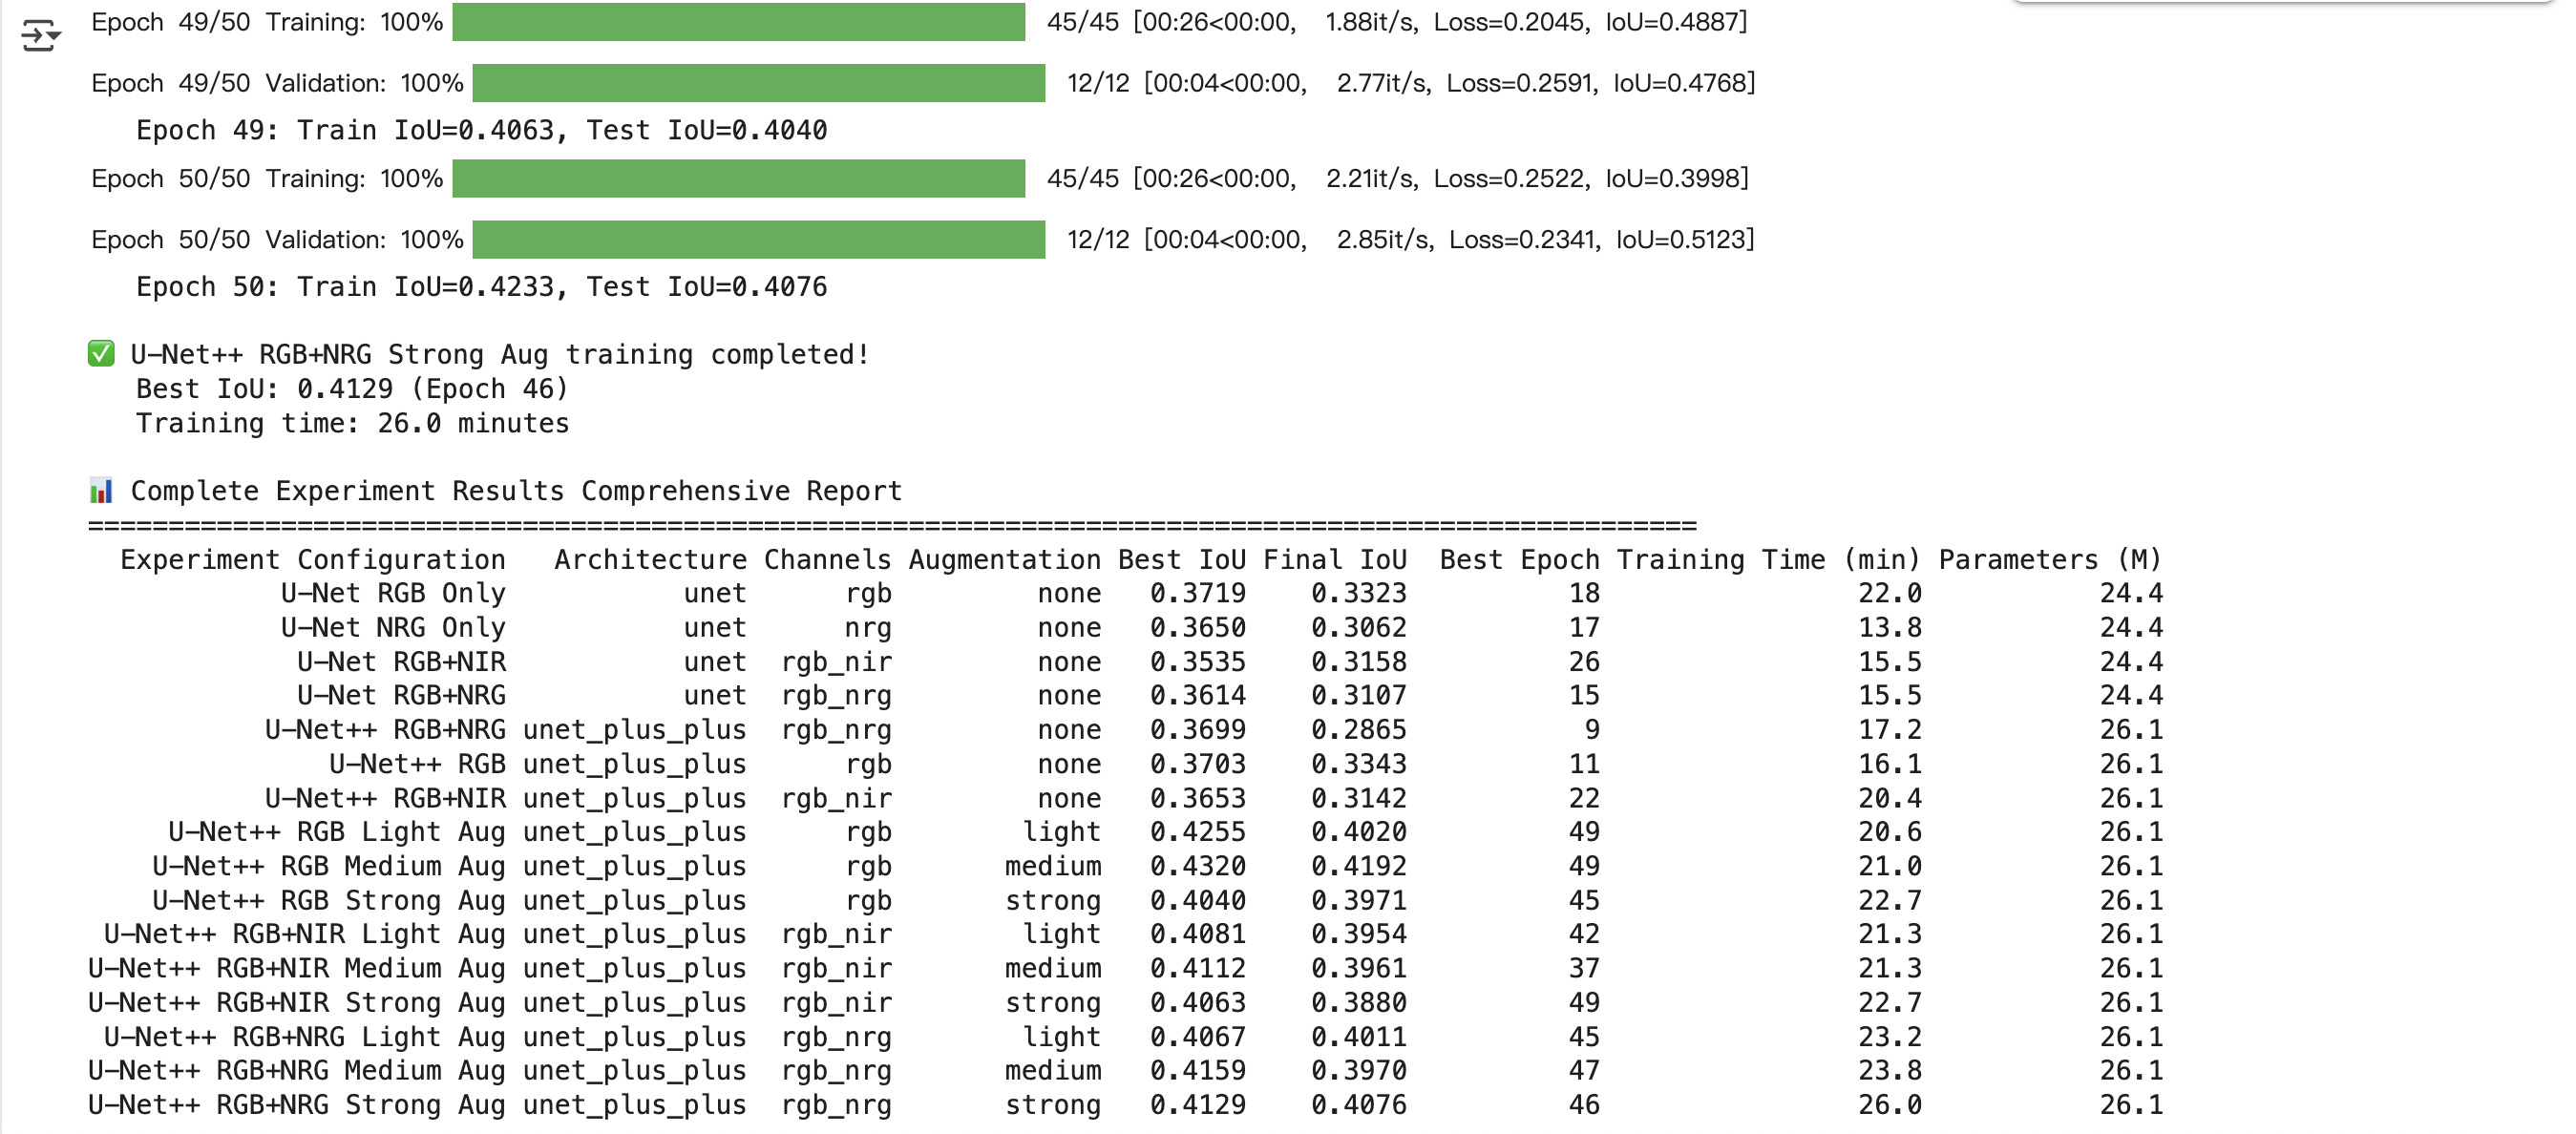

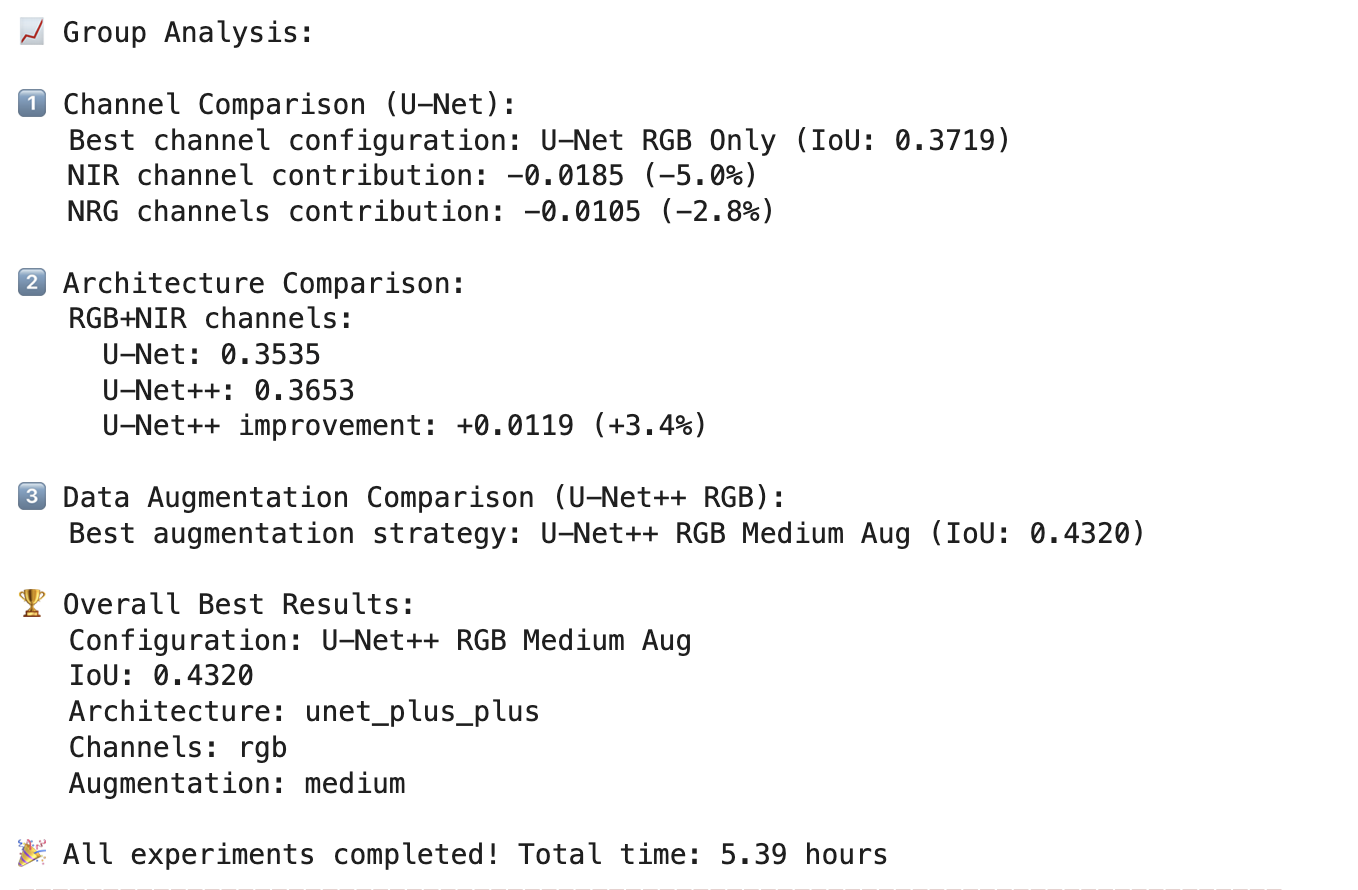